In [145]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
sns.set_style("dark")
from sklearn import tree
# from sklearn.linear_model import LogisticRegressionCV
# from sklearn.preprocessing import scale

## functions

## Get the data

In [11]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender =pd.read_csv("gender_submission.csv")

In [12]:
y_train = train['Survived']
X_train = train.drop(['Survived','PassengerId','Name','Cabin','Ticket'],1)

In [17]:
print(train.columns)
print(X_train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked'], dtype='object')


In [14]:
X_test = test.drop(['PassengerId','Name','Cabin','Ticket'],1)

(array([ 678.,  118.,   80.,    5.,    4.,    6.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

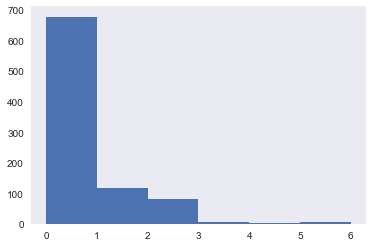

In [53]:
plt.hist(X_train['Parch'],bins=range(7))

In [56]:
pd.crosstab(train['Survived'],train['Parch'])

Parch,0,1,2,3,4,5,6
Survived,,,,,,,
0,445,53,40,2,4,4,1
1,233,65,40,3,0,1,0


In [57]:
pd.crosstab(train['Survived'],train['SibSp'])

SibSp,0,1,2,3,4,5,8
Survived,,,,,,,
0,398,97,15,12,15,5,7
1,210,112,13,4,3,0,0


In [62]:
len(X_train['Ticket'].unique())

681

In [7]:
X_train.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [8]:
X_train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [31]:
X_train['Sex'] = X_train['Sex'].map(lambda val: 1 if val =='male'  else 0 )

In [9]:
X_train.shape

(891, 9)

In [8]:
len(X_train['Ticket'].unique())

681

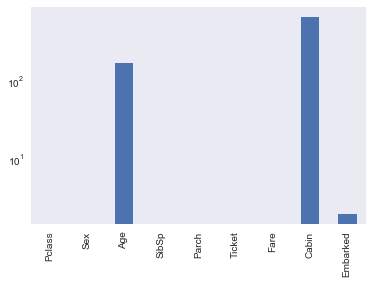

In [28]:
X_train.isnull().sum().plot('bar', logy = True)

In [29]:
X_train.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

(array([ 732.,  106.,   31.,    2.,   11.,    6.,    0.,    0.,    0.,    3.]),
 array([   0.     ,   51.23292,  102.46584,  153.69876,  204.93168,
         256.1646 ,  307.39752,  358.63044,  409.86336,  461.09628,
         512.3292 ]),
 <a list of 10 Patch objects>)

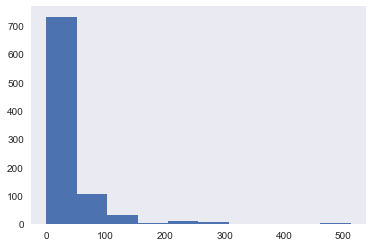

In [65]:
plt.hist(X_train['Fare'])

In [80]:
fare = X_train['Fare'].unique()
train[train['Fare'] == np.max(fare) ]
# sorted(fare)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


In [110]:
pd.crosstab(train['Survived'],train['Embarked'])

Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


In [9]:
X_train[X_train.columns[X_train.dtypes == 'int64']]

In [133]:
real_age[real_age['Survived']==0]['Age']

0      22.0
4      35.0
6      54.0
7       2.0
12     20.0
13     39.0
14     14.0
16      2.0
18     31.0
20     35.0
24      8.0
27     19.0
30     40.0
33     66.0
34     28.0
35     42.0
37     21.0
38     18.0
40     40.0
41     27.0
49     18.0
50      7.0
51     21.0
54     65.0
57     28.5
59     11.0
60     22.0
62     45.0
63      4.0
67     19.0
       ... 
833    23.0
834    18.0
836    21.0
840    20.0
841    16.0
843    34.5
844    17.0
845    42.0
847    35.0
848    28.0
850     4.0
851    74.0
852     9.0
854    44.0
860    41.0
861    21.0
864    24.0
867    31.0
870    26.0
872    33.0
873    47.0
876    20.0
877    19.0
881    33.0
882    22.0
883    28.0
884    25.0
885    39.0
886    27.0
890    32.0
Name: Age, Length: 424, dtype: float64

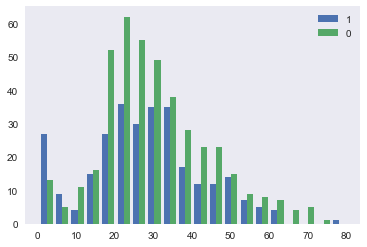

In [141]:
real_age =train[~train['Age'].isnull()]
plt.figure()
plt.hist([real_age[real_age['Survived']==1]['Age'],real_age[real_age['Survived']==0]['Age']],label=['1','0'],bins=20)
plt.legend()

In [144]:
pd.crosstab(real_age['Survived'],real_age['Age'] >= 10)#.map(lambda age: if age >= 10 True else False)

Age,False,True
Survived,,
0,24,400
1,38,252


In [146]:
clf = tree.DecisionTreeClassifier()

In [160]:
model = clf.fit(real_age[['Age']],real_age['Survived'])

# types

In [9]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [24]:
train["SibSp"].unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int64)

In [25]:
test['SibSp'].unique()

array([0, 1, 2, 3, 4, 5, 8], dtype=int64)

In [33]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


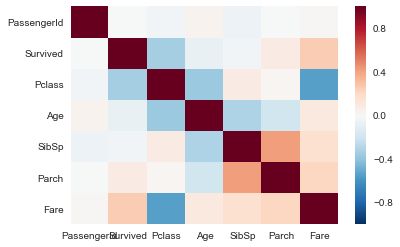

In [38]:
sns.heatmap(train.corr())